# Predicting AirBNB Price

This collab notebook is written for Bangkit Task 5. 

In this book, we utilise Tensorflow to predict AirBNB price based on the public dataset available at : https://www.kaggle.com/stevezhenghp/airbnb-price-prediction

Some of the features are cut out of the sample data to reduce data size. The resulting file is uploaded to Google Drive ([airbnb_price.csv](https://drive.google.com/open?id=1S5hFEprXxLUEfsnQ0sczo_smmc3tA49D)) and referred in the code.

In [0]:
# Importing data pydrive as per example: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=k9q0pp33dckN
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticating and getting file instance
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Creating file
csv_url = "https://drive.google.com/open?id=1S5hFEprXxLUEfsnQ0sczo_smmc3tA49D"
file_id = csv_url.split('=')[-1]

csv_file = drive.CreateFile({'id':file_id}) 
csv_file.GetContentFile('airbnb_price.csv')  

In [0]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('airbnb_price.csv')
df = pd.DataFrame.from_records(data)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df.head()

,Unnamed: 0,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,instant_bookable,bedrooms,beds
0,0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,f,1.0,1.0
1,1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,t,3.0,3.0
2,2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,t,1.0,3.0
3,3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,f,2.0,2.0
4,4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,t,0.0,1.0


Preparing data : 
- Renaming columns
- Scoring `amenities` by the number of amenities offered
- Replacing and categorizing `property_type`
- Filling missing values in `bathrooms`, `bedrooms` and `beds`

And converting one-hot categorical values

In [0]:
# rename id to airbnb_id, and Unnamed: 0 to row_id
df = df.rename(columns={'Unnamed: 0' : 'row_id', 'id' : 'airbnb_id'})

df['amenities'] = df['amenities'].apply(lambda x: x.replace('{', '').replace('}', '').replace("'", '').replace('"', '').replace(' ', '_'))
df['amenities'] = df['amenities'].str.split(',').str.len()


# Replace properties into houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    })

# Replace other properties with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

#Fill Missing value 
df['bathrooms'].fillna(df['bathrooms'].mean(), inplace=True)
df['beds'].fillna(df['beds'].mean(), inplace=True)
df['bedrooms'].fillna(df['bedrooms'].mean(), inplace=True)

#convert categorical column into dummy 
df['instant_bookable'] = df['instant_bookable'].apply(lambda x: {"t":1, "f":0}.get(x,x))
df['cleaning_fee']= df['cleaning_fee'].replace({True: 1, False: 0})

df = pd.concat([df, pd.get_dummies(df['property_type'], prefix='property_type')], axis=1)
df = pd.concat([df, pd.get_dummies(df['cancellation_policy'], prefix='cancellation_policy')], axis=1)
df = pd.concat([df, pd.get_dummies(df['city'], prefix="city")], axis=1)
df = pd.concat([df, pd.get_dummies(df['room_type'], prefix="room_type")], axis=1)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   row_id                               74111 non-null  int64  
 1   airbnb_id                            74111 non-null  int64  
 2   log_price                            74111 non-null  float64
 3   property_type                        74111 non-null  object 
 4   room_type                            74111 non-null  object 
 5   amenities                            74111 non-null  int64  
 6   accommodates                         74111 non-null  int64  
 7   bathrooms                            74111 non-null  float64
 8   bed_type                             74111 non-null  object 
 9   cancellation_policy                  74111 non-null  object 
 10  cleaning_fee                         74111 non-null  int64  
 11  city                        

Data prep is done. Now we can prepare the data for the model.
Data is shuffled and split  into training (70%) and test (30%) set.

In [0]:
#shuffling data
shuffled_df = df.reindex(np.random.permutation(df.index))

import math
training_split_line = math.floor(shuffled_df['row_id'].count() * 0.7)

#Split training (70%) and testing (30%)
training_df = shuffled_df.iloc[:training_split_line, :]
test_df = shuffled_df.iloc[training_split_line: , :]

print("Number of rows : ")
print("training_df : " + str(training_df['row_id'].count()))
print("testing_df : " + str(test_df['row_id'].count()))

Number of rows : 
training_df : 51877
testing_df : 22234


Once the data is split, is it prepped for training in Tensorflow. Features are chosen accordingly,

In [0]:
# import tensorflow as tf
%tensorflow_version 1.x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Choose features to train

features = ['amenities',
            'accommodates',
            'bathrooms',
            'cleaning_fee',
            'instant_bookable',
            'bedrooms',
            'beds',
            'property_type_Apartment',
            'property_type_House',
            'property_type_Other',
            'cancellation_policy_flexible',
            'cancellation_policy_moderate',
            'cancellation_policy_strict',
            'cancellation_policy_super_strict_30',
            'cancellation_policy_super_strict_60',
            'city_Boston',
            'city_Chicago',
            'city_DC',
            'city_LA',
            'city_NYC',
            'city_SF',
            'room_type_Entire home/apt',
            'room_type_Private room',
            'room_type_Shared room']

# Load the entire data into a matrix
x_train = np.matrix(training_df.loc[:, features]).transpose()

# Load entire label intro matrix
y_train = np.matrix(training_df['log_price'])

# And make a convenient variable to remember the number of input columns 
n = len(features)

TensorFlow 1.x selected.
Instructions for updating:
non-resource variables are not supported in the long term


Regression is modelled as y = Ax + b. A and b are tensorflow variables that can change

In [0]:
# Define data placeholders
x = tf.placeholder(tf.float32, shape=(n, None))
y = tf.placeholder(tf.float32, shape=(1, None))

# Define trainable variables
# with tf.variable_scope(reuse=tf.AUTO_REUSE):
A = tf.get_variable("A", shape=(1, n))
b = tf.get_variable("b", shape=())

Model is trained using gradient descent using the chosen hyperparameters. Loss function is calculated with MSE.

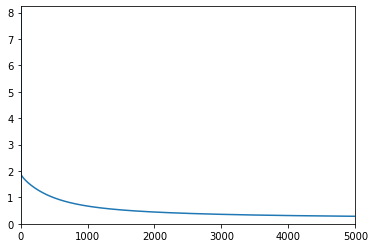

Model loss : 0.2850942313671112


In [0]:
# Define model output
y_predicted = tf.matmul(A, x) + b

# Define the loss function
loss = tf.reduce_mean(tf.square(y_predicted - y))

learning_rate = 0.001
training_epochs = 5000
loss_history = np.empty(shape=[1],dtype=float)

# Define optimizer object
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# Create a session and initialize variables
session = tf.Session()
session.run(tf.global_variables_initializer())

# Main optimization loop
for epoch in range(training_epochs):
    _, current_loss, current_A, current_b = session.run([training_step, loss, A, b], feed_dict={
        x: x_train,
        y: y_train
    })
    loss_history = np.append(loss_history,session.run(loss,feed_dict={x: x_train, y: y_train}))

# plot the loss
plt.plot(range(len(loss_history)),loss_history)
plt.axis([0,training_epochs,0,np.max(loss_history)])
plt.show()

print("Model loss : " + str(loss_history[-1]))

Once we have trained the model, we can test it on the test set

Test MSE: 0.2811


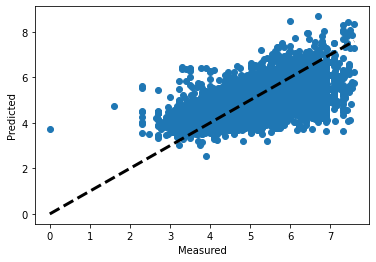

In [0]:
# Prepare test data
x_test = np.matrix(test_df.loc[:, features]).transpose()

# Load entire label intro matrix
y_test = np.matrix(test_df['log_price'])

# Make some predictions on test dataset and calculate mean square error
prediction_y_test = session.run(y_predicted, feed_dict={x: x_test})
mse = tf.reduce_mean(tf.square(prediction_y_test - y_test))
print("Test MSE: %.4f" % session.run(mse))

y_test = np.ravel(y_test.sum(axis=0))
prediction_y_test = prediction_y_test[0]

fig, ax = plt.subplots()
ax.scatter(y_test, prediction_y_test)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

The test MSE is quite close to the model's MSE. Therefore, the model performs quite well at the test.

Now let's see how much difference is made by the model as it predicts the price.

In [0]:
# Take 100 random examples from the test set
sample_set = test_df.sample(100)
samples = sample_set.loc[:, features].transpose()

# Make some predictions on test dataset and calculate mean square error
sample_test = session.run(y_predicted, feed_dict={x: samples})

# Compile predicted data and real price
compare = pd.DataFrame({'predicted' : np.exp(sample_test[0]), 'real_price' : np.exp(sample_set['log_price'].values)})
compare['difference'] = np.abs(compare['predicted'] - compare['real_price'])
compare['percent_difference'] = compare['difference'] / compare['real_price'] * 100

compare.head()

,predicted,real_price,difference,percent_difference
0,192.087280,169.0,23.087280,13.661113
1,316.571564,150.0,166.571564,111.047709
2,139.341507,38.0,101.341507,266.688176
3,203.348816,104.0,99.348816,95.527708
4,54.052170,30.0,24.052170,80.173899


In [0]:
print(f"On average, the predicted price is " + str(round(compare['percent_difference'].mean(), 2)) + "% more or less than the real price")

On average, the predicted price is 46.04% more or less than the real price
